# Example from Lederer et al '19

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import numpy.linalg as la
import mosek
import mosek.fusion as fusion
import cvxpy as cp

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def f(x1, x2):
    return 1 - np.sin(x1) + 1/(1+np.exp(-x2))

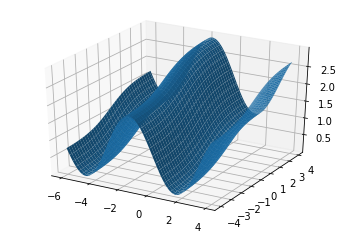

In [3]:
X1 = np.arange(-6,4,0.1)
X2 = np.arange(-4,4,0.1)
X1, X2 = np.meshgrid(X1,X2)
Z = f(X1,X2)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_surface(X1, X2, Z)
#ax.scatter3D(xs_train[:,0], xs_train[:,1], ys_train, color='r')

## Additive case
### First part

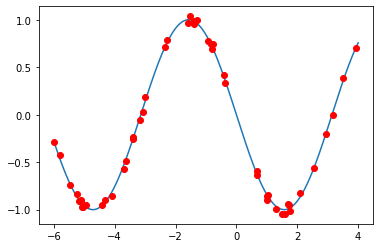

In [4]:
x1_low = -6
x1_high = 4
b_noise_true = 0.05
b_noise = b_noise_true
n_samples = 50
L = 2

slope1_lower = -2
slope1_upper = 2

xs1 = np.linspace(x1_low, x1_high, 1000)

def f1(x):
    #return 0.5*np.sin(x) + 0.5*x
    return -np.sin(x)

ys1 = f1(xs1)

xs1_train = np.sort(np.random.uniform(low=x1_low, high=x1_high, size=n_samples))
ys1_train = f1(xs1_train) + np.random.uniform(low=-b_noise_true, high=b_noise_true, size=n_samples)

plt.plot(xs1,ys1)
plt.plot(xs1_train, ys1_train, 'ro')

In [5]:

ell = 0.5

n_grid1 = 500
xs1_grid = np.linspace(x1_low,x1_high,n_grid1)
delta1 = xs1_grid[1]-xs1_grid[0]

def psi0(x):
    return np.exp(-x**2/(2*ell))

def psi1(x):
    return -1/ell*x*np.exp(-x**2/(2*ell))
    
def psi2(x):
    return (-1/(ell**2) + x**2/(ell**4))*np.exp(-x**2/(2*ell))

xs1_local = np.linspace(0, delta1, 1000)
psi1_local1 = psi1(xs1_local)
delta1_max = xs1_local[np.argmin(psi1_local1[1:]-psi1_local1[:-1]<0)]

eta1 = np.max(np.sqrt(np.abs(2*psi2(0)-2*psi2(xs1_local))))

# Kernel matrix setup
K00 = psi0(xs1_train.reshape([-1,1])-xs1_train.reshape([1,-1]))
K01 = -psi1(xs1_train.reshape([-1,1])-xs1_grid.reshape([1,-1]))
K11 = -psi2(xs1_grid.reshape([-1,1])-xs1_grid.reshape([1,-1]))
K = np.block([
    [K00   , K01],
    [K01.T, K11]
])
K0 = np.block([K00, K01])
K1 = np.block([K01.T, K11])

K_reg = K + 10e-4*np.identity(n_samples+n_grid1)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_samples+n_grid1)

# Optimization problem
M = fusion.Model()

# Variables
n_coeffs = n_samples + n_grid1

## Coefficients arising from the RT
alphas1 = M.variable("alphas1", n_coeffs, fusion.Domain.unbounded())

# Data constraints
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas1), ys1_train), fusion.Domain.lessThan(b_noise))
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas1), ys1_train), fusion.Domain.greaterThan(-b_noise))

# Geometric constraints
## Introduce the expression $K^{\frac{1}{2}}\alpha$ as a variable
x_norm = M.variable("x_norm", n_coeffs, fusion.Domain.unbounded())
M.constraint(fusion.Expr.sub(x_norm, fusion.Expr.mul(K_sqrt, alphas1)), fusion.Domain.equalsTo(0.0))

## Use MOSEK Fusion vectorization
## Lower bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(1/eta1*K1, alphas1), 1/eta1*slope1_lower), 
        fusion.Var.hrepeat(x_norm, n_grid1).transpose()), 
    fusion.Domain.inQCone())

## Upper bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(-1/eta1*K1, alphas1), -1/eta1*slope1_upper), 
        fusion.Var.hrepeat(x_norm, n_grid1).transpose()), 
    fusion.Domain.inQCone())

# Objective function
c_reg = 100

## Quadratic part (incl RKHS norm) via SOC
Q = K0.T @ K0 + c_reg*K
U,s_vals, Vh = la.svd(Q)
Q_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_coeffs)

t_quad = M.variable("t_quad", 1, fusion.Domain.unbounded())
M.constraint(fusion.Expr.vstack(t_quad, 1, fusion.Expr.mul(Q_sqrt, alphas1)), fusion.Domain.inRotatedQCone())

## Linear part
c_vec = -2*K0.T @ ys1_train

## Full objective
M.objective(fusion.ObjectiveSense.Minimize, fusion.Expr.add(t_quad, fusion.Expr.dot(c_vec, alphas1)))

# Run the optimization problem
M.solve()
print(M.getProblemStatus())

ProblemStatus.PrimalAndDualFeasible


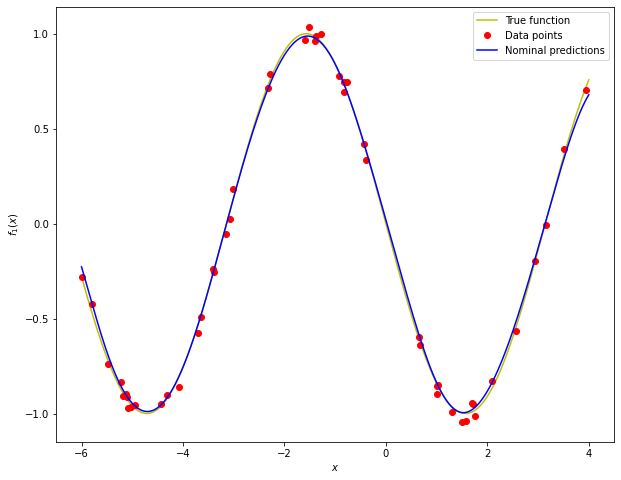

In [6]:
alphas1_val = M.getVariable("alphas1").level()
ys1_pred = np.block([
    psi0(xs1.reshape([-1,1]) - xs1_train.reshape([1,-1])),
    -psi1(xs1.reshape([-1,1]) - xs1_grid.reshape([1,-1]))
]) @ alphas1_val

plt.figure(figsize=(10,8))
plt.plot(xs1, ys1, '-y')
plt.plot(xs1_train, ys1_train, 'ro')
plt.plot(xs1, ys1_pred, 'b-')

plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.legend(["True function", "Data points", "Nominal predictions"])

In [7]:
def ub1(x):
    return np.min(ys1_train + b_noise + L*np.abs(xs1_train - x))

def lb1(x):
    return np.max(ys1_train - b_noise - L*np.abs(xs1_train - x))

ubs1 = np.array([ub1(x) for x in xs1])
lbs2 = np.array([lb1(x) for x in xs1])

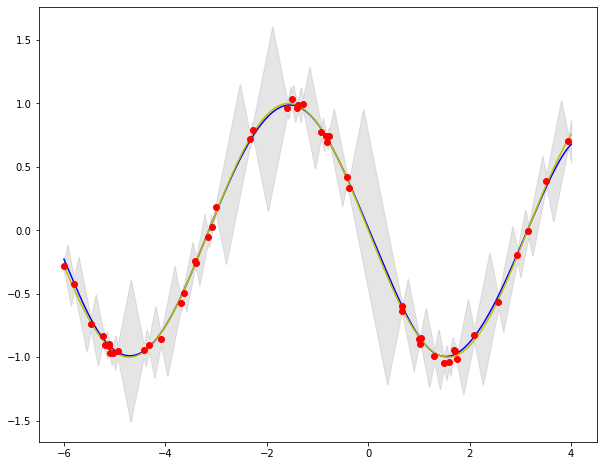

In [8]:
plt.figure(figsize=(10,8))
plt.plot(xs1, ys1_pred, 'b-')
plt.plot(xs1, ys1, '-y')
plt.plot(xs1_train, ys1_train, 'ro')

plt.fill_between(xs1, [lb1(x) for x in xs1], [ub1(x) for x in xs1], color='gray', alpha=0.2)

In [9]:
# Get eta
# We use the approach from https://github.com/PCAubin/Hard-Shape-Constraints-for-Kernels/blob/main/code/ToyQuadratic_MonotonousLeastSquares.m
xs_local = np.linspace(0, 10*ell, 1000)
psi1_local = psi1(xs_local)
delta_max = xs_local[np.argmin(psi1_local[1:]-psi1_local[:-1]<0)]

# Virtual points (grid used for SOC)
n_grid = 200
xs1_smooth_grid = np.linspace(x1_low,x1_high,n_grid)
delta = xs1_smooth_grid[1]-xs1_smooth_grid[0]
eta = np.sqrt(2*psi0(0)-2*psi0(delta))
#eta = 0.1

#lambda_obj = cp.Variable()
#lambda_ub = cp.Variable()

K = psi0(xs1_smooth_grid.reshape([-1,1])-xs1_smooth_grid.reshape([1,-1]))
K_reg = K + 10e-4*np.identity(n_grid)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_grid)

ub_grid = np.array([ub1(x) for x in xs1_smooth_grid])
lb_grid = np.array([lb1(x) for x in xs1_smooth_grid])

beta = cp.Variable([n_grid,1])
constraints_ub = [cp.SOC(K[i,:] @ beta - ub_grid[i], eta*K_sqrt @ beta) for i in range(n_grid)]
#constraints_cumulative = [cp.quad_form(beta, K_reg) <= lambda_obj]
#constraints_obj = [cp.sum(K_reg @ beta - ub_grid.reshape([-1,1])) <= lambda_ub]

prob = cp.Problem(
    cp.Minimize(cp.sum(K_reg @ beta - ub_grid.reshape([-1,1]))),
    constraints_ub
)
prob.solve()
beta1_ub = beta.value

constraints_lb = [cp.SOC(-K[i,:] @ beta + lb_grid[i], eta*K_sqrt @ beta) for i in range(n_grid)]

prob = cp.Problem(
    cp.Minimize(cp.sum(lb_grid.reshape([-1,1]) - K_reg @ beta )),
    constraints_lb
)
prob.solve(solver=cp.MOSEK)
beta1_lb = beta.value

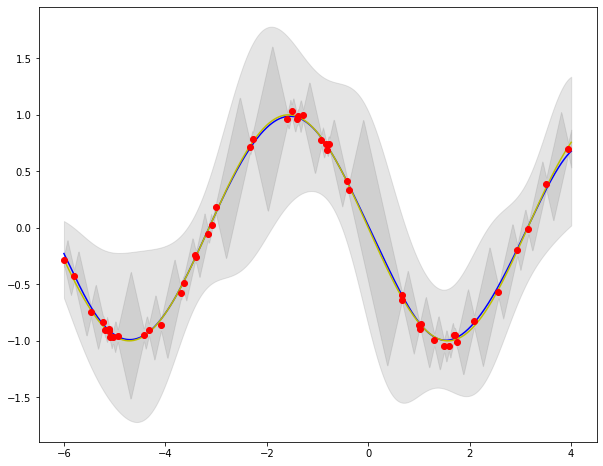

In [10]:
plt.figure(figsize=(10,8))
plt.plot(xs1, ys1_pred, 'b-')
plt.plot(xs1, ys1, '-y')
plt.plot(xs1_train, ys1_train, 'ro')

plt.fill_between(xs1, [lb1(x) for x in xs1], [ub1(x) for x in xs1], color='gray', alpha=0.2)

K_plot2 = psi0(xs1.reshape([-1,1])-xs1_smooth_grid.reshape([1,-1]))
plt.fill_between(xs1, (K_plot2@beta1_lb).flatten(), (K_plot2@beta1_ub).flatten(), color='gray', alpha=0.2,label= "Smoothed uncertainty set")


# Second part

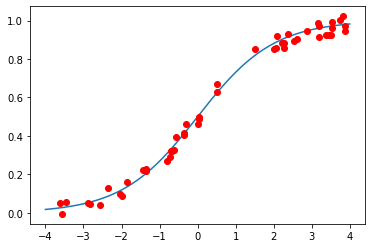

In [11]:
x2_low = -4
x2_high = 4
b_noise_true = 0.05
b_noise = b_noise_true
n_samples = 50
L = 2

slope2_lower = -2
slope2_upper = 2

xs2 = np.linspace(x2_low, x2_high, 1000)

def f2(x):
    return 1/(1+np.exp(-x))

ys2 = f2(xs2)

xs2_train = np.sort(np.random.uniform(low=x2_low, high=x2_high, size=n_samples))
ys2_train = f2(xs2_train) + np.random.uniform(low=-b_noise_true, high=b_noise_true, size=n_samples)

plt.plot(xs2,ys2)
plt.plot(xs2_train, ys2_train, 'ro')

In [12]:
ell = 0.5

n_grid2 = 100
xs2_grid = np.linspace(x2_low,x2_high,n_grid2)
delta2 = xs1_grid[1]-xs1_grid[0]

xs2_local = np.linspace(0, delta2, 1000)
psi1_local2 = psi1(xs2_local)
delta2_max = xs2_local[np.argmin(psi1_local2[1:]-psi1_local2[:-1]<0)]

eta2 = np.max(np.sqrt(np.abs(2*psi2(0)-2*psi2(xs2_local))))

# Kernel matrix setup
K00 = psi0(xs2_train.reshape([-1,1])-xs2_train.reshape([1,-1]))
K01 = -psi1(xs2_train.reshape([-1,1])-xs2_grid.reshape([1,-1]))
K11 = -psi2(xs2_grid.reshape([-1,1])-xs2_grid.reshape([1,-1]))
K = np.block([
    [K00   , K01],
    [K01.T, K11]
])
K0 = np.block([K00, K01])
K1 = np.block([K01.T, K11])

K_reg = K + 10e-4*np.identity(n_samples+n_grid2)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_samples+n_grid2)

# Optimization problem
M = fusion.Model()

# Variables
n_coeffs = n_samples + n_grid2

## Coefficients arising from the RT
alphas2 = M.variable("alphas2", n_coeffs, fusion.Domain.unbounded())

# Data constraints
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas2), ys2_train), fusion.Domain.lessThan(b_noise))
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas2), ys2_train), fusion.Domain.greaterThan(-b_noise))

# Geometric constraints
## Introduce the expression $K^{\frac{1}{2}}\alpha$ as a variable
x_norm = M.variable("x_norm", n_coeffs, fusion.Domain.unbounded())
M.constraint(fusion.Expr.sub(x_norm, fusion.Expr.mul(K_sqrt, alphas2)), fusion.Domain.equalsTo(0.0))

## Use MOSEK Fusion vectorization
## Lower bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(1/eta2*K1, alphas2), 1/eta2*slope2_lower), 
        fusion.Var.hrepeat(x_norm, n_grid2).transpose()), 
    fusion.Domain.inQCone())

## Upper bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(-1/eta2*K1, alphas2), -1/eta2*slope2_upper), 
        fusion.Var.hrepeat(x_norm, n_grid2).transpose()), 
    fusion.Domain.inQCone())

# Objective function
c_reg = 100

## Quadratic part (incl RKHS norm) via SOC
Q = K0.T @ K0 + c_reg*K
U,s_vals, Vh = la.svd(Q)
Q_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_coeffs)

t_quad = M.variable("t_quad", 1, fusion.Domain.unbounded())
M.constraint(fusion.Expr.vstack(t_quad, 1, fusion.Expr.mul(Q_sqrt, alphas2)), fusion.Domain.inRotatedQCone())

## Linear part
c_vec = -2*K0.T @ ys2_train

## Full objective
M.objective(fusion.ObjectiveSense.Minimize, fusion.Expr.add(t_quad, fusion.Expr.dot(c_vec, alphas2)))

# Run the optimization problem
M.solve()
print(M.getProblemStatus())

ProblemStatus.PrimalAndDualFeasible


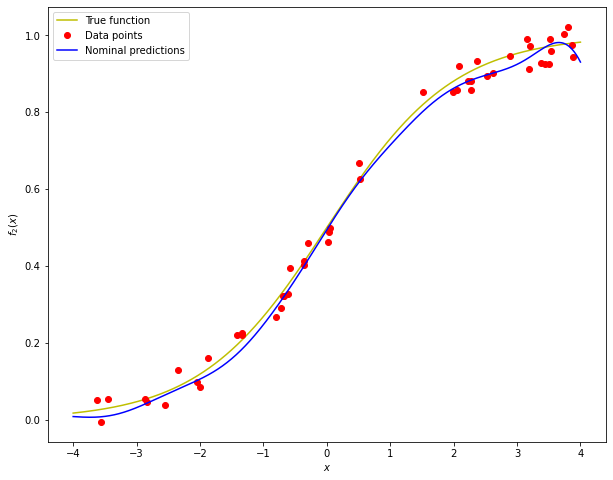

In [13]:
alphas2_val = M.getVariable("alphas2").level()
ys2_pred = np.block([
    psi0(xs2.reshape([-1,1]) - xs2_train.reshape([1,-1])),
    -psi1(xs2.reshape([-1,1]) - xs2_grid.reshape([1,-1]))
]) @ alphas2_val

plt.figure(figsize=(10,8))
plt.plot(xs2, ys2, '-y')
plt.plot(xs2_train, ys2_train, 'ro')
plt.plot(xs2, ys2_pred, 'b-')

plt.xlabel("$x$")
plt.ylabel("$f_2(x)$")
plt.legend(["True function", "Data points", "Nominal predictions"])

In [14]:
def ub2(x):
    return np.min(ys2_train + b_noise + L*np.abs(xs2_train - x))

def lb2(x):
    return np.max(ys2_train - b_noise - L*np.abs(xs2_train - x))

ubs2 = np.array([ub2(x) for x in xs2])
lbs2 = np.array([lb2(x) for x in xs2])

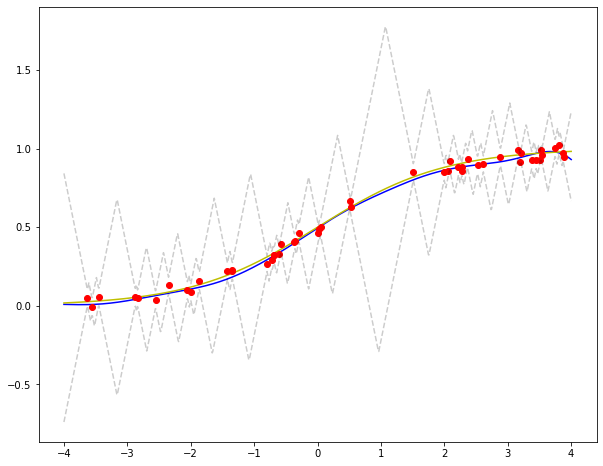

In [15]:
plt.figure(figsize=(10,8))
plt.plot(xs2, ys2_pred, 'b-')
plt.plot(xs2, ys2, '-y')
plt.plot(xs2_train, ys2_train, 'ro')

#plt.fill_between(xs2, [lb2(x) for x in xs2], [ub2(x) for x in xs2], color='gray', alpha=0.2)
plt.plot(xs2, [lb2(x) for x in xs2], 'k--', alpha=0.2)
plt.plot(xs2, [ub2(x) for x in xs2], 'k--', alpha=0.2)

In [16]:
# Get eta
# We use the approach from https://github.com/PCAubin/Hard-Shape-Constraints-for-Kernels/blob/main/code/ToyQuadratic_MonotonousLeastSquares.m
xs_local = np.linspace(0, 10*ell, 1000)
psi1_local = psi1(xs_local)
delta_max = xs_local[np.argmin(psi1_local[1:]-psi1_local[:-1]<0)]

# Virtual points (grid used for SOC)
n_grid = 200
xs2_smooth_grid = np.linspace(x2_low,x2_high,n_grid)
delta = xs2_smooth_grid[1]-xs2_smooth_grid[0]
eta = np.sqrt(2*psi0(0)-2*psi0(delta))
#eta = 0.1

#lambda_obj = cp.Variable()
#lambda_ub = cp.Variable()

K = psi0(xs2_smooth_grid.reshape([-1,1])-xs2_smooth_grid.reshape([1,-1]))
K_reg = K + 10e-4*np.identity(n_grid)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_grid)

ub_grid = np.array([ub2(x) for x in xs2_smooth_grid])
lb_grid = np.array([lb2(x) for x in xs2_smooth_grid])

beta = cp.Variable([n_grid,1])
constraints_ub = [cp.SOC(K[i,:] @ beta - ub_grid[i], eta*K_sqrt @ beta) for i in range(n_grid)]
#constraints_cumulative = [cp.quad_form(beta, K_reg) <= lambda_obj]
#constraints_obj = [cp.sum(K_reg @ beta - ub_grid.reshape([-1,1])) <= lambda_ub]

prob = cp.Problem(
    cp.Minimize(cp.sum(K_reg @ beta - ub_grid.reshape([-1,1]))),
    constraints_ub
)
prob.solve()
beta2_ub = beta.value

constraints_lb = [cp.SOC(-K[i,:] @ beta + lb_grid[i], eta*K_sqrt @ beta) for i in range(n_grid)]

prob = cp.Problem(
    cp.Minimize(cp.sum(lb_grid.reshape([-1,1]) - K_reg @ beta )),
    constraints_lb
)
prob.solve(solver=cp.MOSEK)
beta2_lb = beta.value

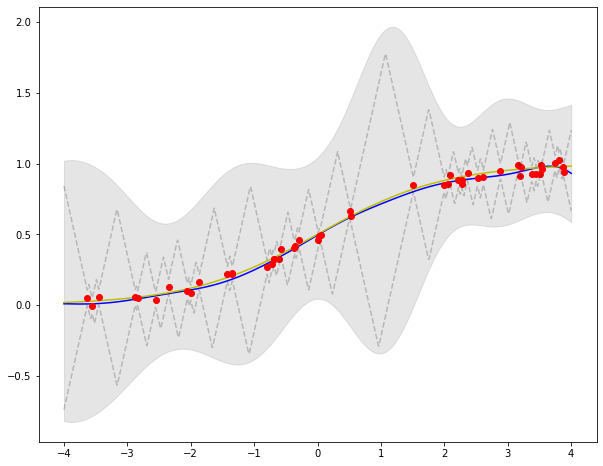

In [17]:
plt.figure(figsize=(10,8))
plt.plot(xs2, ys2_pred, 'b-')
plt.plot(xs2, ys2, '-y')
plt.plot(xs2_train, ys2_train, 'ro')

plt.plot(xs2, [lb2(x) for x in xs2], 'k--', alpha=0.2)
plt.plot(xs2, [ub2(x) for x in xs2], 'k--', alpha=0.2)
 
K_plot2 = psi0(xs2.reshape([-1,1])-xs2_smooth_grid.reshape([1,-1]))
plt.fill_between(xs2, (K_plot2@beta2_lb).flatten(), (K_plot2@beta2_ub).flatten(), color='gray', alpha=0.2,label= "Smoothed uncertainty set")


## Build predictor and uncertainty set
### Nominal prediction

In [18]:
def f_pred(x1, x2):
    f1 = np.block([
        psi0(x1 - xs1_train.reshape([1,-1])),
        -psi1(x1  - xs1_grid.reshape([1,-1]))
    ]) @ alphas1_val
    
    f2 = np.block([
        psi0(x2 - xs2_train.reshape([1,-1])),
        -psi1(x2 - xs2_grid.reshape([1,-1]))
    ]) @ alphas2_val

    return 1 + f1 + f2

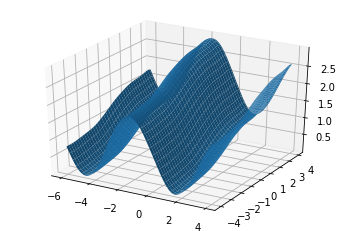

In [19]:
X1 = np.arange(-6,4,0.1)
X2 = np.arange(-4,4,0.1)
X1, X2 = np.meshgrid(X1,X2)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X2.shape[1]):
        Z[i,j] = f_pred(X1[i,j], X2[i,j])
        
#Z = f_pred(X1,X2)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
_ = ax.plot_surface(X1, X2, Z)
#ax.scatter3D(xs_train[:,0], xs_train[:,1], ys_train, color='r')

### Uncertainty set

In [20]:
def uncertainty_bound(x1, x2):
    return (
        1 +
        np.max(ys1_train - b_noise - L*np.abs(xs1_train - x1)) +
        np.max(ys2_train - b_noise - L*np.abs(xs2_train - x2)),
        1 +
        np.min(ys1_train + b_noise + L*np.abs(xs1_train - x1)) +
        np.min(ys2_train + b_noise + L*np.abs(xs2_train - x2))
    )

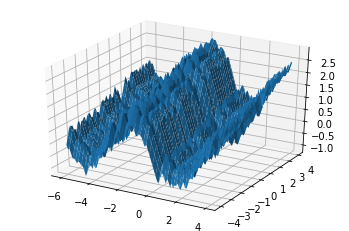

In [21]:
X1 = np.arange(-6,4,0.1)
X2 = np.arange(-4,4,0.1)
X1, X2 = np.meshgrid(X1,X2)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X2.shape[1]):
        Z[i,j] = uncertainty_bound(X1[i,j], X2[i,j])[0]
        
#Z = f_pred(X1,X2)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
_ = ax.plot_surface(X1, X2, Z)
#ax.scatter3D(xs_train[:,0], xs_train[:,1], ys_train, color='r')

In [22]:
# Uncertainty width
X1 = np.arange(-6,4,0.1)
X2 = np.arange(-4,4,0.1)
X1, X2 = np.meshgrid(X1,X2)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X2.shape[1]):
        Z[i,j] = uncertainty_bound(X1[i,j], X2[i,j])[1] - uncertainty_bound(X1[i,j], X2[i,j])[0]

### Smoothed uncertainty set

In [23]:
def ub_smoothed(x1, x2):
    ub1 = psi0(x1 - xs1_smooth_grid.reshape([1,-1])) @ beta1_ub
    
    ub2 = psi0(x2 - xs2_smooth_grid.reshape([1,-1])) @ beta2_ub

    return ub1 + ub2

def lb_smoothed(x1, x2):
    lb1 = psi0(x1 - xs1_smooth_grid.reshape([1,-1])) @ beta1_lb
    
    lb2 = psi0(x2 - xs2_smooth_grid.reshape([1,-1])) @ beta2_lb

    return lb1 + lb2

def uncertainty_bound_smoothed(x1, x2):
    return (
        lb_smoothed(x1,x2),
        ub_smoothed(x1,x2)
    )

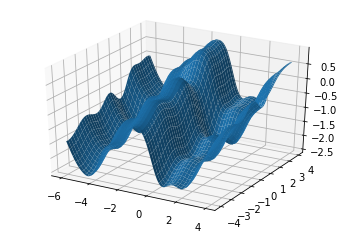

In [24]:
X1 = np.arange(-6,4,0.1)
X2 = np.arange(-4,4,0.1)
X1, X2 = np.meshgrid(X1,X2)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X2.shape[1]):
        Z[i,j] = lb_smoothed(X1[i,j], X2[i,j])[0]
        
#Z = f_pred(X1,X2)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
_ = ax.plot_surface(X1, X2, Z)
#ax.scatter3D(xs_train[:,0], xs_train[:,1], ys_train, color='r')

## Run simulation for example
### Closed loop with nominal prediction

In [25]:
def x_ref_full(t):
    return np.array([2*np.sin(t), 2*np.cos(t), -2*np.sin(t)]).T
    
k_c = 2
lambda_c = 1

def rhs(t,x):
    e1 = x[0] - x_ref_full(t)[0]
    e2 = x[1] - x_ref_full(t)[1]
    nu = x_ref_full(t)[2] - k_c*(lambda_c*e1 + e2) - lambda_c*e2
    return np.array([
        x[1], 
        f(x[0], x[1]) - f_pred(x[0],x[1]).item() + nu
    ])

t_sim_max = 30
#n_sim = 200
n_sim = 1000
ts = np.linspace(0, t_sim_max, n_sim)
x0 = np.zeros(2)
ivp_sol = solve_ivp(rhs, (0, t_sim_max), x0, t_eval=ts)

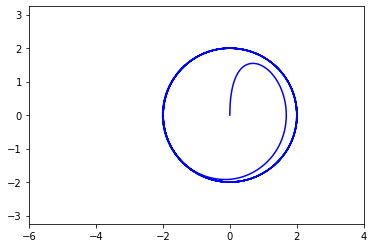

In [26]:
xs_ref = x_ref_full(np.linspace(0, t_sim_max, 1000))[:,:2]

fig, ax = plt.subplots()
ax.axis('equal')
ax.set(xlim=(-6,4), ylim=(-4,4))
plt.plot(xs_ref[:,0], xs_ref[:,1], 'g--')

plt.plot(ivp_sol.y[0,:], ivp_sol.y[1,:], 'b-')

### Ultimate boundedness region from uncertainty set

In [27]:
# Error trajectory
es = ivp_sol.y.T - x_ref_full(ts)[:,:2]

# Uncertainty set, evaluated on the closed loop trajectory
bs = [uncertainty_bound(ivp_sol.y[0,i], ivp_sol.y[1,i]) for i in range(n_sim)]

# Uncertainty widths on the closed loop trajectory
uncertainty_widths = np.array([b[1]-b[0] for b in bs])

# Build grid for UB region computation
n_lf_grid = 500
xs1_lf_grid = np.linspace(x1_low, x1_high, n_lf_grid)
xs2_lf_grid = np.linspace(x2_low, x2_high, n_lf_grid)
xs_lf_grid = np.vstack([
    np.repeat(xs1_lf_grid, [n_lf_grid]*n_lf_grid), 
    np.tile(xs2_lf_grid, n_lf_grid)
]).T

# Indicators (for each simulation time step) for containment in UB region
contained_in_ub_region = np.zeros((n_sim, xs_lf_grid.shape[0]))

for ind_sim in range(n_sim):
    lb_sim, ub_sim = uncertainty_bound(ivp_sol.y[0,ind_sim], ivp_sol.y[1,ind_sim])
    uncertainty_width = ub_sim - lb_sim
    x_ref_sim = x_ref_full(ivp_sol.t[ind_sim])[:2]
    contained_in_ub_region[ind_sim,:] = la.norm(xs_lf_grid-x_ref_sim, axis=1) \
        <= uncertainty_width/(k_c*np.sqrt(lambda_c**2+1))
    
# Area of UB region
ub_region_areas = np.zeros(n_sim)
for i in range(n_sim):
    inds_ub_region = np.nonzero(contained_in_ub_region[i,:])[0]
    ub_region_points = xs_lf_grid[inds_ub_region,:]
    ub_region_cvx = ConvexHull(ub_region_points)
    ub_region_areas[i] = ub_region_cvx.volume

In [28]:
rs = np.zeros(n_sim)

for ind_sim in range(n_sim):
    x_ref_sim = x_ref_full(ivp_sol.t[ind_sim])[:2]
    
    lb_sim, ub_sim = uncertainty_bound(ivp_sol.y[0,ind_sim], ivp_sol.y[1,ind_sim])
    uncertainty_width = ub_sim - lb_sim
    rs[ind_sim] = uncertainty_width/(k_c*np.sqrt(lambda_c**2+1)) 

### UB region from smoothed uncertainty set

In [29]:
# Uncertainty set, evaluated on the closed loop trajectory
bs_smoothed = [uncertainty_bound_smoothed(ivp_sol.y[0,i], ivp_sol.y[1,i]) for i in range(n_sim)]

# Uncertainty widths on the closed loop trajectory
uncertainty_widths_smoothed = np.array([b[1]-b[0] for b in bs])

# Indicators (for each simulation time step) for containment in UB region
contained_in_ub_region_smoothed = np.zeros((n_sim, xs_lf_grid.shape[0]))

for ind_sim in range(n_sim):
    lb_sim, ub_sim = uncertainty_bound_smoothed(ivp_sol.y[0,ind_sim], ivp_sol.y[1,ind_sim])
    uncertainty_width = ub_sim - lb_sim
    x_ref_sim = x_ref_full(ivp_sol.t[ind_sim])[:2]
    contained_in_ub_region_smoothed[ind_sim,:] = la.norm(xs_lf_grid-x_ref_sim, axis=1) \
        <= uncertainty_width/(k_c*np.sqrt(lambda_c**2+1))
    
# Area of UB region
ub_region_areas_smoothed = np.zeros(n_sim)
for i in range(n_sim):
    inds_ub_region = np.nonzero(contained_in_ub_region_smoothed[i,:])[0]
    ub_region_points = xs_lf_grid[inds_ub_region,:]
    ub_region_cvx = ConvexHull(ub_region_points)
    ub_region_areas_smoothed[i] = ub_region_cvx.volume

In [30]:
rs_smoothed = np.zeros(n_sim)

for ind_sim in range(n_sim):
    x_ref_sim = x_ref_full(ivp_sol.t[ind_sim])[:2]
    
    lb_sim, ub_sim = uncertainty_bound_smoothed(ivp_sol.y[0,ind_sim], ivp_sol.y[1,ind_sim])
    uncertainty_width = ub_sim - lb_sim
    rs_smoothed[ind_sim] = uncertainty_width/(k_c*np.sqrt(lambda_c**2+1))

## Plotting

In [31]:
X1 = np.arange(-6.2,4.2,0.1)
#X2 = np.arange(-4,4,0.1)
X2 = np.arange(-3.2,3.2,0.1)
X1, X2 = np.meshgrid(X1,X2)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X2.shape[1]):
        lb,ub = uncertainty_bound(X1[i,j], X2[i,j])
        Z[i,j] = ub - lb

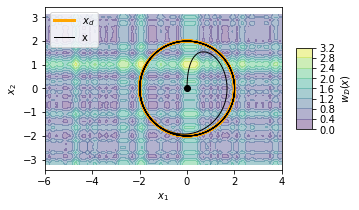

In [32]:
fig, ax = plt.subplots(figsize=(0.5*10,0.5*6))
ax.axis('equal')

background_plot = ax.contourf(X1,X2,Z, cmap=plt.get_cmap('viridis'), alpha=0.4)
fig.colorbar(background_plot, fraction=0.1,shrink=0.5, aspect=5, pad=0.05, label='$w_\mathcal{D}(x)$')

# Initial state
plt.plot(0,0, 'ko')

# Reference trajectory
xs_ref = x_ref_full(np.linspace(0, t_sim_max, 1000))[:,:2]
plt.plot(xs_ref[:,0], xs_ref[:,1], '-', color='orange', lw=3, label='$x_d$')

# Closed loop trajectory
plt.plot(ivp_sol.y[0,:], ivp_sol.y[1,:], 'k-', label='x', lw=1)

plt.legend(loc='upper left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

#ax.contour(X1, X2, Z)
#ax.set(xlim=(-6,4), ylim=(-4,4))
ax.set(xlim=(-6,4), ylim=(-3,3))

plt.savefig('output/control_traj.pdf', bbox_inches="tight")

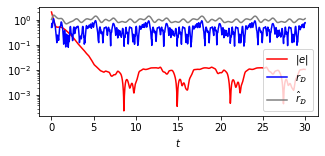

In [33]:
plt.figure(figsize=(5,2))
plt.plot(ts, la.norm(es, axis=1), color='r', label="$\|e\|$")
plt.plot(ts, rs, color='b', label="$r_\mathcal{D}$")
plt.plot(ts, rs_smoothed, color='gray', label="$\hat r_\mathcal{D}$")
plt.yscale('log')
plt.xlabel('$t$')
plt.legend(loc="lower right")

plt.savefig('output/control_errors.pdf', bbox_inches="tight")